# Covid-19: From model prediction to model predictive control

## Scenario-analysis with the age-stratified deterministic model

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook was made to quickly perform scenario analysis with the age-stratified model implementation.

### Load required packages

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
import datetime
import scipy
from scipy.integrate import odeint
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st
import networkx # to install networkx in your environment: conda install networkx
from covid19model.models import models
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import polymod
from covid19model.data import parameters
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load interaction matrices

In [2]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = polymod.get_interaction_matrices()

### Load parameter values for age-stratified deterministic model

In [4]:
params = parameters.get_COVID19_SEIRD_parameters()

In [5]:
params.update({'Nc':Nc_total})

### Scrape high-level Sciensano data and Google Community mobility reports

In [32]:
index,startdate,H_tot, H_tot_cumsum, ICU_tot, H_in, H_out= sciensano.get_sciensano_COVID19_data(update=False)
#dates,retail_recreation,grocery,parks,transport,work,residential=google.get_google_mobility_data()

## Refactored model

In [33]:
levels = initN.size
initial_states = {'S': initN, 'E': np.ones(levels)}

In [34]:
model = models.COVID19_SEIRD(initial_states, params)

### Run model for some time

In [39]:
from covid19model.visualization import output

In [41]:
# -> user runs a simulation for a defined time period
time = [0, 200]
out = model.sim(time)

In [58]:
#out['E'].sum(dim='stratification').plot()

In [62]:
out.parameters['beta']

0.03492

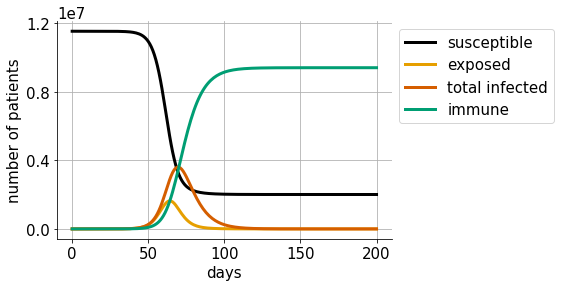

In [43]:
output.population_status(out)

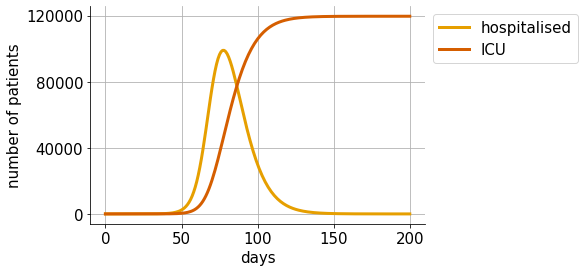

In [42]:
output.infected(out)

## Old model

### Perform calibration

First calibrate $\beta$ and $t_e$ to the NEW hospitalizations during the first days of the pandemic. The new hospitalizations does not depend on the length of hospital stay!

In [ ]:
data=[np.transpose(H_in[:,0:7])]
# set optimisation settings
parNames = ['extraTime','beta'] # must be a list!
positions = [np.array([14])] # must be a list!
bounds=((20,80),(0.01,0.08)) # must be a list!
weights = np.array([1])
# run optimisation
theta = fit(model,data,parNames,positions,bounds,weights,setvar=True,maxiter=50,popsize=100)

In [ ]:
# plot result
model.plotFit(index[0:7],data,positions,modelClr=['red','orange','blue','yellow'],legendText=('H_in (model)','H_in (data)'),titleText='Belgium')

Then calibrate hospitalization lengths from the actual peak.

In [ ]:
sigma = 0.5
Nc1 = Nc_home+((1-0.20)*Nc_work+(1-0.20)*Nc_transport+0.5*Nc_leisure)
Nc2 = 0.6*Nc_home+((1-0.50)*Nc_work+(1-0.50)*Nc_transport)
Nc3 = 0.3*Nc_home+sigma*((1-0.70)*Nc_work+(1-0.70)*Nc_transport)

# Create a dictionary of past policies
chk = {'t':       [model.extraTime+2,model.extraTime+7,model.extraTime+12], 
       'Nc':      [Nc1,Nc2,Nc3]
      }

data=[np.transpose(H_in[:,0:50]),np.transpose(H_out[:,0:50])]
# set optimisation settings
parNames = ['dc'] # must be a list!
positions = [np.array([14]),np.array([15])] # must be a list!
bounds=[((1,15))] # must be a list!
weights = np.array([1,1])
# run optimisation
#theta = model.fit(data,parNames,positions,bounds,weights,checkpoints=chk,setvar=True,maxiter=30,popsize=100)

In [ ]:
model.dc=10.49
# plot result
model.plotFit(index[0:50],data,positions,checkpoints=chk,modelClr=['red','orange','blue','yellow'],legendText=('H_in (model)','H_out (model)','H_in (data)','H_out (data)'),titleText='Belgium')

In [ ]:
sigma = 0.5
Nc1 = Nc_home+((1-0.20)*Nc_work+(1-0.20)*Nc_transport+0.5*Nc_leisure)
Nc2 = 0.6*Nc_home+((1-0.50)*Nc_work+(1-0.50)*Nc_transport)
Nc3 = 0.3*Nc_home+sigma*((1-0.70)*Nc_work+(1-0.70)*Nc_transport)

# Create a dictionary of past policies
chk = {'t':       [model.extraTime+2,model.extraTime+7,model.extraTime+13], 
       'Nc':      [Nc1,Nc2,Nc3]
      }

data=[np.transpose(H_in[:,0:55]),np.transpose(H_out[:,0:55])]
# set optimisation settings
parNames = ['dc','dICU'] # must be a list!
positions = [np.array([14]),np.array([15])] # must be a list!
bounds=((7,12),(6,16)) # must be a list!
weights = np.array([1,1])
# run optimisation
theta = model.fit(data,parNames,positions,bounds,weights,checkpoints=chk,setvar=True,maxiter=10,popsize=100)

In [ ]:
# plot result
model.plotFit(index[0:55],data,positions,checkpoints=chk,modelClr=['red','orange','blue','yellow'],legendText=('H_in (model)','H_out (model)','H_in (data)','H_out (data)'),titleText='Belgium')

In [ ]:
sigma = 0.5
Nc1 = Nc_home+((1-0.20)*Nc_work+(1-0.20)*Nc_transport+0.5*Nc_leisure)
Nc2 = 0.6*Nc_home+((1-0.50)*Nc_work+(1-0.50)*Nc_transport)
Nc3 = 0.3*Nc_home+sigma*((1-0.70)*Nc_work+(1-0.70)*Nc_transport)

# Create a dictionary of past policies
chk = {'t':       [model.extraTime+2,model.extraTime+7,model.extraTime+13], 
       'Nc':      [Nc1,Nc2,Nc3]
      }

data=[np.transpose(H_in[:,0:55]),np.transpose(H_out[:,0:55])]
# set optimisation settings
parNames = ['dc','dICU','dICUrec'] # must be a list!
positions = [np.array([14]),np.array([15])] # must be a list!
bounds=((5,11),(10,16),(4,9)) # must be a list!
weights = np.array([1,1])
# run optimisation
theta = model.fit(data,parNames,positions,bounds,weights,checkpoints=chk,setvar=True,maxiter=10,popsize=300)
# plot result
model.plotFit(index[0:55],data,positions,checkpoints=chk,modelClr=['red','orange','blue','yellow'],legendText=('H_in (model)','H_out (model)','H_in (data)','H_out (data)'),titleText='Belgium')

In [ ]:
model.dc = 11.93
model.dICU = 9.07
model.dICUrec = 7.49

In [ ]:
sigma = 0.7
Nc1 = Nc_home+((1-0.20)*Nc_work+(1-0.20)*Nc_transport+0.5*Nc_leisure)
Nc2 = 0.6*Nc_home+((1-0.50)*Nc_work+(1-0.50)*Nc_transport)
Nc3 = 0.3*Nc_home+sigma*((1-0.70)*Nc_work+(1-0.70)*Nc_transport)

# Create a dictionary of past policies
chk = {'t':       [model.extraTime+2,model.extraTime+8,model.extraTime+10], 
       'Nc':      [Nc1,Nc2,Nc3]
      }

data=[np.transpose(ICU_tot[:,0:55]),np.transpose(H_tot_cumsum[:,0:55])]
# set optimisation settings
parNames = ['dc','dICU','dICUrec'] # must be a list!
positions = [np.array([6]),np.array([5,6])] # must be a list!
bounds=((6,12),(6,10),(4,9)) # must be a list!
weights = np.array([9,1])
# run optimisation
theta = model.fit(data,parNames,positions,bounds,weights,checkpoints=chk,setvar=True,maxiter=10,popsize=100)
# plot result
model.plotFit(index[0:55],data,positions,checkpoints=chk,modelClr=['red','orange','blue','yellow'],legendText=('H_in (model)','H_out (model)','H_in (data)','H_out (data)'),titleText='Belgium')

Slight underestimation of hospitalizations, most likely due to the fact that residence times in the hospital differ from the values used in our model. Using the UZ Ghent data to estimate distributions and incorporating this uncertainty will surely fix this in the future.

### Sample from the posterior distribution of beta

For now, the high-level python package `pyMC3` is used to sample from the posterior distribution of $\beta$. However, due to the high level nature of `pyMC3` it is hard to perform an elegant coupling with the BIOMATH covid-19 model. Because the parameter $\beta$ and the excess time $t_e$ are correlated, we fix the $t_e$ estimate obtained from MLE during the sampling procedure to avoid having a bi- or trimodal distributions for $\beta$.

In [ ]:
import pymc3 as pm
import theano
import theano.tensor as tt
from theano.compile.ops import as_op

In [ ]:
# Redefine estimated parameters using MLE
model.dc = 11.93
model.dICU = 9.07
model.dICUrec = 7.49
model.extraTime = int(round(37.36))
model.beta = 0.03492
# Length of dataset
n=theano.shared(float(ICU_tot[:,0:55].size))

# Define coupling function of pyMC3-ICU 
@as_op(itypes=[tt.dscalar,tt.dscalar,tt.dscalar,tt.dscalar,tt.dscalar], otypes=[tt.dvector])
def coupleICU2COVID19MODEL(beta,dc,dICU,dICUrec,n):
    model.beta = beta
    model.dc = dc
    model.dICU = dICU
    model.dICUrec = dICUrec
    T = n+model.extraTime-1
    model.sim(T,checkpoints=chk)
    mdl_out = (model.sumS,model.sumE,model.sumI,model.sumA,model.sumM,model.sumCtot,model.sumICU,model.sumR,model.sumD,model.sumSQ,model.sumEQ,model.sumAQ,model.sumMQ,model.sumRQ,model.sumH_in,model.sumH_out)
    positions = np.array([6])
    som = 0
    for idx in positions:
        som = som + np.mean(mdl_out[idx],axis=1).reshape(np.mean(mdl_out[idx],axis=1).size,1)
    return som[int(model.extraTime):].flatten()

# Define coupling function of pyMC3-Hospital 
@as_op(itypes=[tt.dscalar,tt.dscalar,tt.dscalar,tt.dscalar,tt.dscalar], otypes=[tt.dvector])
def coupleH2COVID19MODEL(beta,dc,dICU,dICUrec,n):
    model.beta = beta
    model.dc = dc
    model.dICU = dICU
    model.dICUrec = dICUrec
    T = n+model.extraTime-1
    model.sim(T,checkpoints=chk)
    mdl_out = (model.sumS,model.sumE,model.sumI,model.sumA,model.sumM,model.sumCtot,model.sumICU,model.sumR,model.sumD,model.sumSQ,model.sumEQ,model.sumAQ,model.sumMQ,model.sumRQ,model.sumH_in,model.sumH_out)
    positions = np.array([5,6])
    som = 0
    for idx in positions:
        som = som + np.mean(mdl_out[idx],axis=1).reshape(np.mean(mdl_out[idx],axis=1).size,1)
    return som[int(model.extraTime):].flatten()

# Define prior distributions of parameters
with pm.Model() as COVID19MODEL:
    db = pm.backends.Text('test')
    BoundedNormal = pm.Bound(pm.Normal, lower=1.0)
    # Priors for unknown model parameters
    beta = pm.Normal('beta', mu=model.beta, sigma=0.01)
    dc = BoundedNormal('dc', mu=model.dc, sigma=0.1)
    dICU = BoundedNormal('dICU', mu=model.dICU, sigma=0.1)
    dICUrec = BoundedNormal('dICUrec', mu=model.dICUrec, sigma=0.1)
    sigma_ICU = pm.HalfNormal('sigma_ICU', sigma=10)
    sigma_H = pm.HalfNormal('sigma_H', sigma=10)

    mu_ICU = coupleICU2COVID19MODEL(beta,dc,dICU,dICUrec,n)
    mu_H = coupleH2COVID19MODEL(beta,dc,dICU,dICUrec,n)
    # Likelihood (sampling distribution) of observations
    ICU_obs = pm.Normal('ICU_obs', mu=mu_ICU, sigma=sigma_ICU, observed=ICU_tot[:,0:55].flatten())
    H_obs = pm.Normal('H_obs', mu=mu_H, sigma=sigma_H, observed=H_tot[:,0:55].flatten())

In [ ]:
map_estimate = pm.find_MAP(model=COVID19MODEL, method='L-BFGS-B',tol=1e-6)
map_estimate

In [ ]:
with COVID19MODEL:

    # draw 1000 posterior samples
    trace = pm.sample(2,start=map_estimate,step=pm.Slice(),cores=8,trace=db)

In [ ]:
tracedict = {
    'beta': np.asarray(trace['beta']),
    'dc': np.asarray(trace['dc']),
    'dICU': np.asarray(trace['dICU']),
    'dICUrec': np.asarray(trace['dICUrec'])
}

# save a copy in the raw folder
abs_dir = os.path.dirname(__file__)
rel_dir = os.path.join(abs_dir, '../../data/interim/model_parameters/trace.csv')

(pd.DataFrame.from_dict(data=tracedict, orient='index')
   .to_csv(reldir, header=False))

In [ ]:
pm.traceplot(trace,varnames=['beta','dc','dICU','dICUrec'])

### Scenarios


Use the code snippet below to see the correspondence between `'t'` in the `pastPolicy` dictionary and the actual date.

In [ ]:
# Define data as a list containing data timeseries
data=[np.transpose(ICU_tot),np.transpose(H_tot)]
print(index[2],index[50],index[57],index[-1])

The interaction matrices of the 2008 study by Mossong were gathered under a business-as-usual scenario. It is thus not possible to use the interaction matrices without doing a correction for social distancing. Even when using only the interactions at home (`Nc_home`), the virus cannot be stopped.

In [ ]:
sigma = 1

Stringent measures were taken in the evening of March 17th, which corresponds to time-index 3, however, the measures are only 'enforced' on day 8 in the `pastPolicy` dictionary. Why? The change in human behaviour was very gradual, it took between 10-14 days after March 17th before everyone was working at home (see the Google mobility report). In other words, measures were taken on March 17th, but obedience for these measures was gradual, like a ramp. However, in the model we make a step-wise change. The obedience to measures can be adressed in future work.

Another important issue to adress is the home interaction matrix `Nc_home`. All contacts in these matrices are still assumed to be random, during a lockdown, the interactions at home should somehow be corrected for the 'bubble' effect. Since the average household size in belgium is 2 people, I correct the `Nc_home` matrix with a factor 1/2.

In [ ]:
sigma = 0.6

# Create a dictionary of past policies
pastPolicy = {'t':       [2,8,11,50], 
              'Nc':      [Nc_home+((1-0.20)*Nc_work+(1-0.20)*Nc_transport+0.5*Nc_leisure),
                          0.6*Nc_home+((1-0.50)*Nc_work+(1-0.50)*Nc_transport),
                          0.3*Nc_home+sigma*((1-0.70)*Nc_work+(1-0.70)*Nc_transport),
                          0.3*Nc_home+sigma*((1-0.40)*Nc_work+(1-0.50)*Nc_transport),
                          # 40 percent reduction in work --> google covid mobility reports
                          # 50 percent reduction in transit --> google covid mobility reports (Contact Koen Schoors for data De Lijn!)
                         ]
              }

In [ ]:
# Create a dictionary of future policies
futurePolicy = {'t':     [6], # May 21th, June 4th 
                'Nc':    [0.3*Nc_home+sigma*((1-0.30)*Nc_work+(1-0.40)*Nc_transport+(1-0.50)*Nc_schools)
                         ],
              }

In [ ]:
# Run realTimeScenario
model.realTimeScenario(startdate,data,positions,pastPolicy,futurePolicy=futurePolicy,trace=tracedict,T_extra=93,
                       modelClr=['red','orange'],legendText=('ICU (model)','Hospital (model)','ICU (data)','Hospital (data)'),
                       titleText='Belgium',filename='test.svg')

Save your figures by altering the variable `filename = xxxxx.svg`!